In [5]:
import pandas as pd

# Load dataset (CSV from Kaggle)
df = pd.read_csv('/content/drive/MyDrive/Data.csv')

df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


(           ID       DATOP     FLTID DEPSTN ARRSTN                  STD  \
 0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00   
 1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
 2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
 3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
 4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   
 
                    STA STATUS         AC  target  
 0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
 1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
 2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  
 3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  
 4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0  ,
 None)

In [6]:
# Drop rows with missing delay info
df = df.dropna(subset=['target'])

# Create target: 1 = delayed (30+ min), 0 = not delayed
df['DELAYED'] = (df['target'] >= 30).astype(int)

# Select a few features for simplicity
features = ['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS', 'AC'] # Temporarily using existing object columns as placeholders
X = df[features]
y = df['DELAYED']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert date/time columns to numerical timestamps
X_train['DATOP'] = pd.to_datetime(X_train['DATOP'], format='%Y-%m-%d').astype(int) / 10**9
X_test['DATOP'] = pd.to_datetime(X_test['DATOP'], format='%Y-%m-%d').astype(int) / 10**9

X_train['STD'] = pd.to_datetime(X_train['STD'], format='%Y-%m-%d %H:%M:%S').astype(int) / 10**9
X_test['STD'] = pd.to_datetime(X_test['STD'], format='%Y-%m-%d %H:%M:%S').astype(int) / 10**9

X_train['STA'] = pd.to_datetime(X_train['STA'], format='%Y-%m-%d %H.%M.%S').astype(int) / 10**9
X_test['STA'] = pd.to_datetime(X_test['STA'], format='%Y-%m-%d %H.%M.%S').astype(int) / 10**9

# Identify categorical columns
categorical_cols = ['FLTID', 'DEPSTN', 'ARRSTN', 'STATUS', 'AC']

# Initialize a dictionary to store LabelEncoders
label_encoders = {}

# Apply Label Encoding
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on the combined data to ensure all possible categories are learned
    # and to handle categories that might only appear in test set.
    # Convert to string to handle potential mixed types or non-string objects.
    X_combined_series = pd.concat([X_train[col].astype(str), X_test[col].astype(str)], axis=0)
    le.fit(X_combined_series.unique())

    X_train[col] = le.transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Now X_train and X_test contain numerical and label encoded columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

model = LogisticRegression(max_iter=100)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6586297711339442
              precision    recall  f1-score   support

           0       0.67      0.96      0.79     17855
           1       0.46      0.07      0.12      9104

    accuracy                           0.66     26959
   macro avg       0.57      0.51      0.45     26959
weighted avg       0.60      0.66      0.56     26959



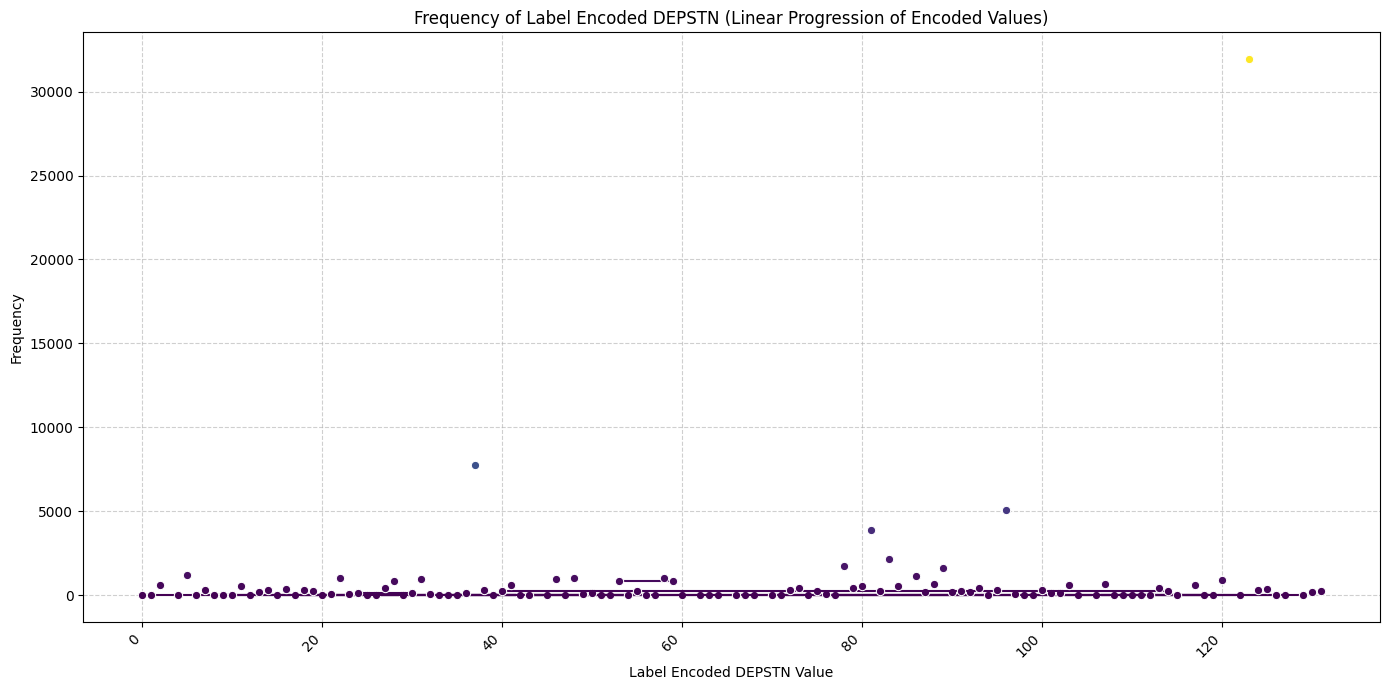


Top 10 most frequent decoded categories for 'DEPSTN':


/tmp/ipython-input-2418992926.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DEPSTN (Decoded)', y='Count', data=top_freq_df, palette='magma')


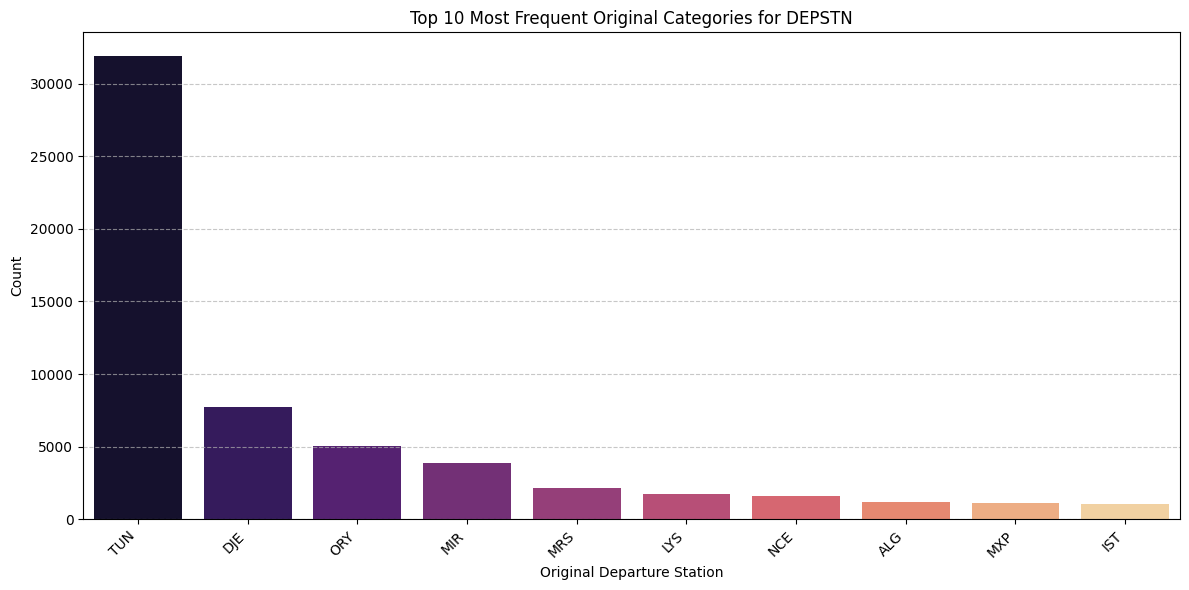

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Choose a label-encoded column for this 'linear' graph
column_for_linear_graph = 'DEPSTN'

# Calculate the value counts for the chosen column in the training data
# We'll then sort by the encoded value to get a 'linear' progression on the x-axis
frequencies = X_train[column_for_linear_graph].value_counts().sort_index()

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Encoded Value': frequencies.index,
    'Count': frequencies.values
})

plt.figure(figsize=(14, 7))
sns.lineplot(x='Encoded Value', y='Count', data=plot_df, marker='o', hue='Count', palette='viridis', legend=False)
plt.title(f'Frequency of Label Encoded {column_for_linear_graph} (Linear Progression of Encoded Values)')
plt.xlabel(f'Label Encoded {column_for_linear_graph} Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# To make it more interpretable, let's also show the top categories with their decoded names on a bar plot
# This provides a clearer view of which original categories correspond to higher frequencies.
print(f"\nTop 10 most frequent decoded categories for '{column_for_linear_graph}':")
le_depstn = label_encoders[column_for_linear_graph]
top_encoded_depstn = X_train[column_for_linear_graph].value_counts().head(10).index.tolist()
top_decoded_depstn = le_depstn.inverse_transform(top_encoded_depstn)

top_freq_df = pd.DataFrame({
    'DEPSTN (Decoded)': top_decoded_depstn,
    'Count': X_train[column_for_linear_graph].value_counts().head(10).values
})

plt.figure(figsize=(12, 6))
sns.barplot(x='DEPSTN (Decoded)', y='Count', data=top_freq_df, palette='magma')
plt.title(f'Top 10 Most Frequent Original Categories for {column_for_linear_graph}')
plt.xlabel('Original Departure Station')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()